# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import utils_stats
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 2. Define hyperparameters and other important variables

In [2]:
target_variable = "Class"
Mean = "Mean"
SD = "SD"
Variance = "Variance"
Range = "Range"

timestamp_col = "DATETIME"

target_sequence_length = 1

test_size = 0.30

first_day_test = "2022-01-01 00:00:00" #21/2/2022  18:53:00 

last_day_test = "2022-06-04 17:46:00" #4/6/2022  17:46:00

hyperparameters = {
    "in_length" : 5,
    "step_size" : 1,
    "n_estimators" : 20,     #an optimal number of trees
    "max_depth" : 6,         #This should be between 3-10. 4-6 can be good starting points
    "subsample" : 0.5,       #This is a commonly used used start value. Typical values range between 0.5-0.9
    "min_child_weight" : 1,  #A smaller value is chosen because it is a highly imbalanced class problem and 
                             #leaf nodes can have smaller size groups
    "selected_features" : [Mean, SD, Variance, Range, target_variable]
    }

# 3. Prepare data

First, we load the data and split it into train and test. It is important that the shuffle argument is False, because we need to maintain the original order of the data points in the data.

In [3]:
spotclasses = utils_stats.load_data()
spotclasses

,Mean,SD,Variance,Range,Class
DATETIME,,,,,
2021-01-07 00:11:00,152.190,13.291947,141.340680,28.45,0
2021-01-07 00:12:00,152.256,13.369126,142.986824,28.34,0
2021-01-07 00:13:00,152.146,13.411698,143.898904,28.22,0
2021-01-07 00:14:00,152.122,13.394236,143.524456,28.34,0
2021-01-07 00:15:00,152.052,13.390699,143.448656,28.34,0
...,...,...,...,...,...
2022-04-06 17:42:00,215.218,13.048447,136.209576,26.31,0
2022-04-06 17:43:00,215.174,13.016059,135.534224,26.19,0
2022-04-06 17:44:00,215.196,12.987018,134.930104,26.08,0


## 3.1 Train Test Split

In [4]:
training_data = spotclasses[spotclasses.index < first_day_test]
training_data

,Mean,SD,Variance,Range,Class
DATETIME,,,,,
2021-01-07 00:11:00,152.190,13.291947,141.340680,28.45,0
2021-01-07 00:12:00,152.256,13.369126,142.986824,28.34,0
2021-01-07 00:13:00,152.146,13.411698,143.898904,28.22,0
2021-01-07 00:14:00,152.122,13.394236,143.524456,28.34,0
2021-01-07 00:15:00,152.052,13.390699,143.448656,28.34,0
...,...,...,...,...,...
2021-12-31 23:55:00,464.606,11.661620,108.794704,27.90,0
2021-12-31 23:56:00,464.672,11.753500,110.515816,28.35,0
2021-12-31 23:57:00,464.534,11.604968,107.740224,27.79,0


In [5]:
test_data = spotclasses[spotclasses.index >= first_day_test]
test_data = test_data[test_data.index <= last_day_test]
test_data

,Mean,SD,Variance,Range,Class
DATETIME,,,,,
2022-01-01 00:00:00,464.514,11.614193,107.911584,28.02,0
2022-01-01 00:01:00,464.492,11.576181,107.206376,27.79,0
2022-01-01 00:02:00,464.536,11.570222,107.096024,28.01,0
2022-01-01 00:03:00,464.516,11.700582,109.522904,28.35,0
2022-01-01 00:04:00,464.514,11.580081,107.278624,27.90,0
...,...,...,...,...,...
2022-04-06 17:42:00,215.218,13.048447,136.209576,26.31,0
2022-04-06 17:43:00,215.174,13.016059,135.534224,26.19,0
2022-04-06 17:44:00,215.196,12.987018,134.930104,26.08,0


## 3.2 Slice data for windowing and create test data for xgboost

In [6]:
# Create indices. Must be passed to function that creates (X,Y) pairs so that
# it knows where to slice the data
training_indices = utils_stats.get_indices_entire_sequence(
    data=training_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=hyperparameters["step_size"]
    )

# Obtain (X,Y) pairs of training data
x_train, y_train = utils_stats.get_xgboost_x_y(
    indices=training_indices, 
    data=training_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

test_indices = utils_stats.get_indices_entire_sequence(
    data=test_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=1
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = utils_stats.get_xgboost_x_y(
    indices=test_indices, 
    data=test_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


In [7]:
x_train

array([[152.19      ,  13.29194681, 141.34068   , ..., 143.448656  ,
         28.34      ,   0.        ],
       [152.256     ,  13.369126  , 142.986824  , ..., 140.826064  ,
         28.23      ,   0.        ],
       [152.146     ,  13.41169751, 143.898904  , ..., 138.314656  ,
         28.        ,   0.        ],
       ...,
       [464.65      ,  11.768751  , 110.8028    , ..., 108.794704  ,
         27.9       ,   0.        ],
       [464.652     ,  11.67593979, 109.062056  , ..., 110.515816  ,
         28.35      ,   0.        ],
       [464.63      ,  11.71442273, 109.78216   , ..., 107.740224  ,
         27.79      ,   0.        ]])

In [8]:
y_train

array([[152.214     ,  13.26772701, 140.826064  ,  28.23      ,
          0.        ],
       [152.032     ,  13.14889045, 138.314656  ,  28.        ,
          0.        ],
       [151.918     ,  13.12935718, 137.904016  ,  27.89      ,
          0.        ],
       ...,
       [464.672     ,  11.75350033, 110.515816  ,  28.35      ,
          0.        ],
       [464.534     ,  11.6049679 , 107.740224  ,  27.79      ,
          0.        ],
       [464.58      ,  11.72943946, 110.0638    ,  28.24      ,
          0.        ]])

In [9]:
x_test

array([[464.514     ,  11.61419304, 107.911584  , ..., 107.278624  ,
         27.9       ,   0.        ],
       [464.492     ,  11.57618115, 107.206376  , ..., 108.566784  ,
         28.24      ,   0.        ],
       [464.536     ,  11.57022169, 107.096024  , ..., 105.448216  ,
         27.79      ,   0.        ],
       ...,
       [215.424     ,  13.21282824, 139.663064  , ..., 136.209576  ,
         26.31      ,   0.        ],
       [215.266     ,  13.08536129, 136.981344  , ..., 135.534224  ,
         26.19      ,   0.        ],
       [215.24      ,  13.07486138, 136.7616    , ..., 134.930104  ,
         26.08      ,   0.        ]])

In [10]:
y_test

array([[464.604     ,  11.64939827, 108.566784  ,  28.24      ,
          0.        ],
       [464.538     ,  11.48086539, 105.448216  ,  27.79      ,
          0.        ],
       [464.562     ,  11.59917756, 107.632736  ,  28.24      ,
          0.        ],
       ...,
       [215.174     ,  13.01605854, 135.534224  ,  26.19      ,
          0.        ],
       [215.196     ,  12.98701775, 134.930104  ,  26.08      ,
          0.        ],
       [215.264     ,  13.06498106, 136.554984  ,  25.98      ,
          0.        ]])

In [11]:
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (264761, 25)
Shape of y_train: (264761, 5)
Shape of x_test: (174950, 25)
Shape of y_test: (174950, 5)


In [12]:
x_train = y_train[:, 0:4] 
x_train

array([[152.214     ,  13.26772701, 140.826064  ,  28.23      ],
       [152.032     ,  13.14889045, 138.314656  ,  28.        ],
       [151.918     ,  13.12935718, 137.904016  ,  27.89      ],
       ...,
       [464.672     ,  11.75350033, 110.515816  ,  28.35      ],
       [464.534     ,  11.6049679 , 107.740224  ,  27.79      ],
       [464.58      ,  11.72943946, 110.0638    ,  28.24      ]])

In [13]:
y_train = y_train[:, 4]
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
x_test = y_test[:, 0:4] 
x_test

array([[464.604     ,  11.64939827, 108.566784  ,  28.24      ],
       [464.538     ,  11.48086539, 105.448216  ,  27.79      ],
       [464.562     ,  11.59917756, 107.632736  ,  28.24      ],
       ...,
       [215.174     ,  13.01605854, 135.534224  ,  26.19      ],
       [215.196     ,  12.98701775, 134.930104  ,  26.08      ],
       [215.264     ,  13.06498106, 136.554984  ,  25.98      ]])

In [15]:
y_test = y_test[:, 4] 
y_test

array([0., 0., 0., ..., 0., 0., 0.])

# 4. Classifier

## 4.1 Train model

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:
# Initialize model
model = xgb.XGBClassifier(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

y_train

trained_model = model.fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

train_cm = confusion_matrix(y_train, train_forecasts)
train_cm

array([[234035,    176],
       [   116,  30434]], dtype=int64)

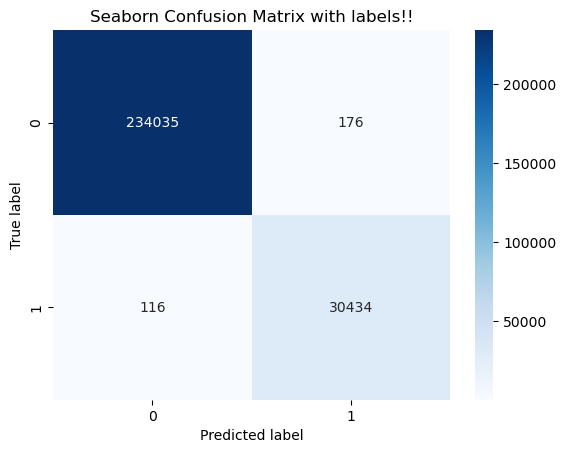

In [31]:
import seaborn as sns

ax = sns.heatmap(train_cm, annot=True, fmt='g', cmap="Blues")

ax.set_title('Seaborn Confusion Matrix with labels!!')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

In [19]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, train_forecasts)
print("Accuracy score: {}".format(acc_train))

Accuracy score: 0.9988971185333188


## 4.2 Test model

In [20]:
test_forecasts = trained_model.predict(x_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
# print(test_mae)
print("Mean Absolute Error: {}".format(test_mae))
# print("Mean test data value: {}".format(np.mean(y_test)))

Mean Absolute Error: 0.0008573878250928837


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

test_cm = confusion_matrix(y_test, test_forecasts)
test_cm

array([[169492,     56],
       [    94,   5308]], dtype=int64)

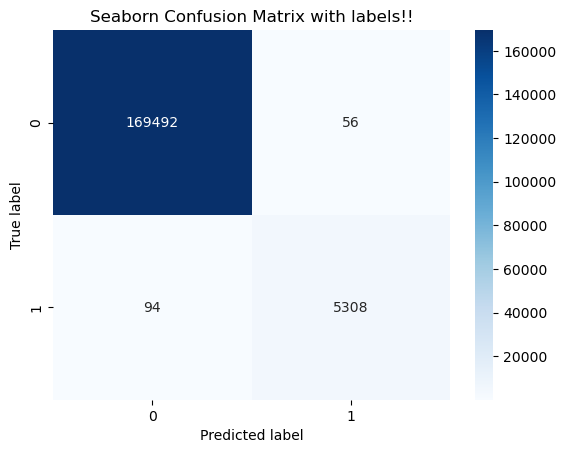

In [30]:
import seaborn as sns

ax = sns.heatmap(test_cm, annot=True, fmt='g', cmap="Blues")

ax.set_title('Seaborn Confusion Matrix with labels!!')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

In [22]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, test_forecasts)
print("Accuracy score: {}".format(acc))

Accuracy score: 0.9991426121749071


# 5. Save the Model

## 5.1 Install Dependencies and Setup

In [53]:
# pip install pyyaml h5py

In [54]:
# import os

# import tensorflow as tf
# from tensorflow import keras

# print(tf.version.VERSION)

## 5.2 Save the Model

In [41]:
# Save the entire model to a HDF5 file.

# Save as JSON file
trained_model.save_model('models/trained_model-HP_Drum_Level-XGBoost-Window_5+1.json')

# Save as TXT file
trained_model.save_model('models/trained_model-HP_Drum_Level-XGBoost-Window_5+1.txt')

## 5.3 Test 11HP_Drum_Level

In [1]:
import xgboost as xgb

In [2]:
# import h5py as h5

# loaded_model = tf.keras.models.load_model('trained_model-HP_Drum_Level-XGBoost-Window_5+1.')

# Blank new instance to be loaded into
xbg_cla = xgb.Booster()

xbg_cla.load_model("../models/trained_model-HP_Drum_Level-XGBoost-Window_5+1.json")

In [3]:
import pandas as pd

In [30]:
test_data = pd.read_csv("../change_datetime_csv/XGBoost-Windowing-HP-Train-11HP_Drum_Level-Test-Change_Datetime.csv", delimiter=",")
test_data.index = pd.to_datetime(test_data["DATETIME"])
test_data.drop(['DATETIME'], axis=1)

,Mean,SD,Variance,Range,Class
DATETIME,,,,,
2022-06-12 10:37:00,-152.225163,16.542885,218.933647,44.988208,0
2022-06-12 10:38:00,-155.087563,16.900798,228.509566,45.995025,0
2022-06-12 10:39:00,-160.398335,16.891930,228.269839,45.957400,0
2022-06-12 10:40:00,-171.106450,17.743946,251.878097,48.422667,0
2022-06-12 10:41:00,-181.790077,17.792495,253.258294,48.385033,0
...,...,...,...,...,...
2022-12-16 18:00:00,183.862695,14.186166,160.997853,30.581183,0
2022-12-16 18:01:00,183.738482,14.280318,163.141986,30.637625,0
2022-12-16 18:02:00,183.732830,14.247713,162.397863,30.581133,0


In [31]:
test_data = test_data[test_data.columns[1:]].to_numpy()
test_data

array([[-152.2251633 ,   16.54288544,  218.933647  ,   44.98820833,
           0.        ],
       [-155.0875633 ,   16.90079754,  228.509566  ,   45.995025  ,
           0.        ],
       [-160.398335  ,   16.89192999,  228.269839  ,   45.9574    ,
           0.        ],
       ...,
       [ 183.73283   ,   14.2477131 ,  162.3978628 ,   30.58113333,
           0.        ],
       [ 183.7478683 ,   14.15027307,  160.1841825 ,   30.59993333,
           0.        ],
       [ 183.77045   ,   14.05269437,  157.9825752 ,   30.59051667,
           0.        ]])

In [32]:
print("Shape of x_test: {}".format(test_data.shape))

Shape of x_test: (14829, 5)


In [33]:
x_test = test_data[:, 0:4] 
x_test

array([[-152.2251633 ,   16.54288544,  218.933647  ,   44.98820833],
       [-155.0875633 ,   16.90079754,  228.509566  ,   45.995025  ],
       [-160.398335  ,   16.89192999,  228.269839  ,   45.9574    ],
       ...,
       [ 183.73283   ,   14.2477131 ,  162.3978628 ,   30.58113333],
       [ 183.7478683 ,   14.15027307,  160.1841825 ,   30.59993333],
       [ 183.77045   ,   14.05269437,  157.9825752 ,   30.59051667]])

In [34]:
y_test = test_data[:, 4] 
y_test

array([0., 0., 0., ..., 0., 0., 0.])

### 5.3.1 Test model

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
# test_forecasts = xbg_cla.predict(x_test)
test_forecasts = xbg_cla.predict(xgb.DMatrix(x_test))
test_mae = mean_absolute_error(y_test, test_forecasts)
# print(test_mae)
print("Mean Absolute Error: {}".format(test_mae))
# print("Mean test data value: {}".format(np.mean(y_test)))

Mean Absolute Error: 0.0034993643608913693


In [37]:
test_forecasts

array([0.00039899, 0.00039899, 0.00039899, ..., 0.00039899, 0.00039899,
       0.00039899], dtype=float32)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
# accuracy_score(y_true, y_pred.round(), normalize=False)
test_cm = confusion_matrix(y_test, test_forecasts.round())
test_cm

array([[14394,    21],
       [    7,   407]], dtype=int64)

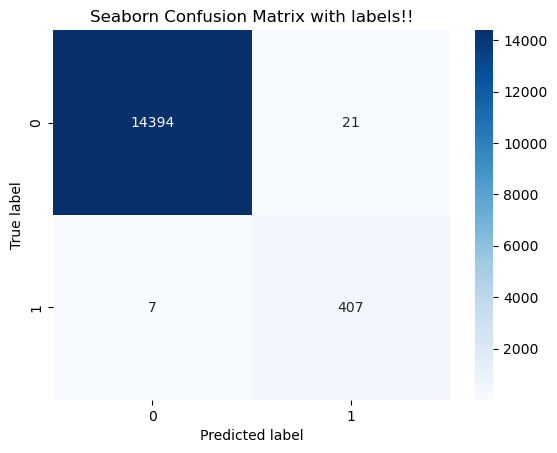

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(test_cm, annot=True, fmt='g', cmap="Blues")

ax.set_title('Seaborn Confusion Matrix with labels!!')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

In [40]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, test_forecasts.round())
print("Accuracy score: {}".format(acc))

Accuracy score: 0.9981118079438938


## 5.4 Test 21IP_Drum_Level

In [41]:
test_data_21ip = pd.read_csv("../change_datetime_csv/21IP_Drum_Level-6_Dec_2022-Statistics-Class-Extract-Change_Datetime.csv", delimiter=",")
test_data_21ip.index = pd.to_datetime(test_data_21ip["DATETIME"])
test_data_21ip

,DATETIME,Mean,SD,Variance,Range,Class
DATETIME,,,,,,
2022-12-06 10:37:08,2022-12-06 10:37:08,-44.972779,3.200481,8.194461,6.894563,0
2022-12-06 10:38:08,2022-12-06 10:38:08,-41.017600,6.837133,37.397111,17.660252,0
2022-12-06 10:39:08,2022-12-06 10:39:08,-44.320090,4.426671,15.676331,11.058298,0
2022-12-06 10:40:08,2022-12-06 10:40:08,-45.076310,5.855765,27.431991,14.614352,0
2022-12-06 10:41:08,2022-12-06 10:41:08,-48.320282,6.676486,35.660377,16.557433,0
...,...,...,...,...,...,...
2022-12-16 18:00:53,2022-12-16 18:00:53,-131.346043,6.440846,33.187594,16.144817,0
2022-12-16 18:01:53,2022-12-16 18:01:53,-131.362542,6.467548,33.463337,16.317367,0
2022-12-16 18:02:53,2022-12-16 18:02:53,-131.487072,6.430353,33.079547,16.174792,0


In [42]:
test_data_21ip.drop(['DATETIME'], axis=1)

,Mean,SD,Variance,Range,Class
DATETIME,,,,,
2022-12-06 10:37:08,-44.972779,3.200481,8.194461,6.894563,0
2022-12-06 10:38:08,-41.017600,6.837133,37.397111,17.660252,0
2022-12-06 10:39:08,-44.320090,4.426671,15.676331,11.058298,0
2022-12-06 10:40:08,-45.076310,5.855765,27.431991,14.614352,0
2022-12-06 10:41:08,-48.320282,6.676486,35.660377,16.557433,0
...,...,...,...,...,...
2022-12-16 18:00:53,-131.346043,6.440846,33.187594,16.144817,0
2022-12-16 18:01:53,-131.362542,6.467548,33.463337,16.317367,0
2022-12-16 18:02:53,-131.487072,6.430353,33.079547,16.174792,0


In [44]:
test_data_21ip = test_data_21ip[test_data_21ip.columns[1:]].to_numpy()
test_data_21ip

array([[ -44.97277933,    3.2004806 ,    8.19446086,    6.89456333,
           0.        ],
       [ -41.01759967,    6.8371331 ,   37.39711123,   17.66025167,
           0.        ],
       [ -44.32009033,    4.42667068,   15.67633061,   11.0582975 ,
           0.        ],
       ...,
       [-131.4870717 ,    6.43035254,   33.07954702,   16.17479167,
           0.        ],
       [-131.5005817 ,    6.53436067,   34.15829544,   16.534925  ,
           0.        ],
       [-131.6176217 ,    6.43592569,   33.13691162,   16.249875  ,
           0.        ]])

In [45]:
print("Shape of x_test: {}".format(test_data_21ip.shape))

Shape of x_test: (14830, 5)


In [46]:
x_test = test_data_21ip[:, 0:4] 
x_test

array([[ -44.97277933,    3.2004806 ,    8.19446086,    6.89456333],
       [ -41.01759967,    6.8371331 ,   37.39711123,   17.66025167],
       [ -44.32009033,    4.42667068,   15.67633061,   11.0582975 ],
       ...,
       [-131.4870717 ,    6.43035254,   33.07954702,   16.17479167],
       [-131.5005817 ,    6.53436067,   34.15829544,   16.534925  ],
       [-131.6176217 ,    6.43592569,   33.13691162,   16.249875  ]])

In [47]:
y_test = test_data_21ip[:, 4] 
y_test

array([0., 0., 0., ..., 0., 0., 0.])

### Test model

In [48]:
# test_forecasts = xbg_cla.predict(x_test)
test_forecasts = xbg_cla.predict(xgb.DMatrix(x_test))
test_mae = mean_absolute_error(y_test, test_forecasts)
# print(test_mae)
print("Mean Absolute Error: {}".format(test_mae))
# print("Mean test data value: {}".format(np.mean(y_test)))

Mean Absolute Error: 0.00039898746831258425


In [49]:
test_forecasts

array([0.00039899, 0.00039899, 0.00039899, ..., 0.00039899, 0.00039899,
       0.00039899], dtype=float32)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
# accuracy_score(y_true, y_pred.round(), normalize=False)
test_cm = confusion_matrix(y_test, test_forecasts.round())
test_cm

array([[14828,     0],
       [    0,     2]], dtype=int64)

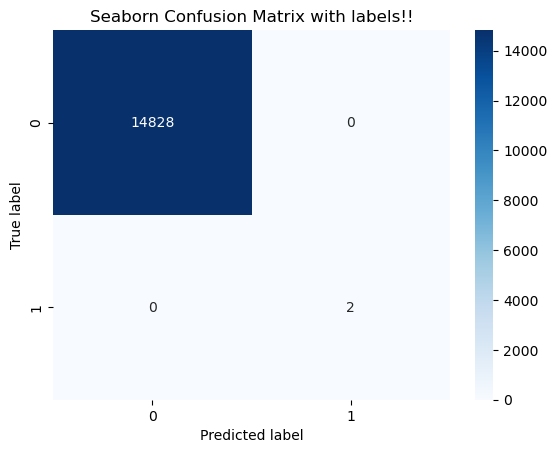

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(test_cm, annot=True, fmt='g', cmap="Blues")

ax.set_title('Seaborn Confusion Matrix with labels!!')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()

In [52]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, test_forecasts.round())
print("Accuracy score: {}".format(acc))

Accuracy score: 1.0
